In [1]:
import torch
import cv2
import matplotlib.pyplot as plt
from segment_anything.build_sam import build_siamese_sam
from segment_anything.dataloader import MedicalDataset
from segment_anything.utils import ContrasiveStructureLoss, LaplacianPyramid
from torchvision.transforms import transforms

In [47]:
sliceimg = 6
num_classes = 3
device = 'cuda'

6
(256, 256)


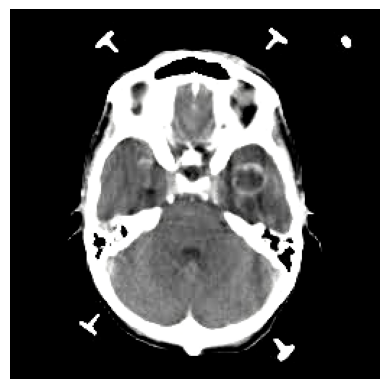

In [48]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/CT/spatial.mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
CT = cap.read()[1]
plt.imshow(CT)
plt.axis('off')
CT = cv2.cvtColor(CT, cv2.COLOR_BGR2GRAY)
print(CT.shape)

6
(256, 256)


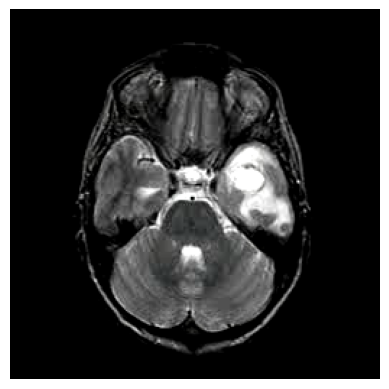

In [49]:
cap = cv2.VideoCapture('./dataset/Neoplastic_Disease/Metastatic_2/MR-T2/spatial (1).mpg')
n = 0
while cap.isOpened():
    ret, frame = cap.read()
    n += 1
    if not ret or n == sliceimg:
        break
print(n)
MRI = cap.read()[1]
plt.imshow(MRI)
plt.axis('off')
MRI = cv2.cvtColor(MRI, cv2.COLOR_BGR2GRAY)
print(MRI.shape)

(256, 256) (256, 256)


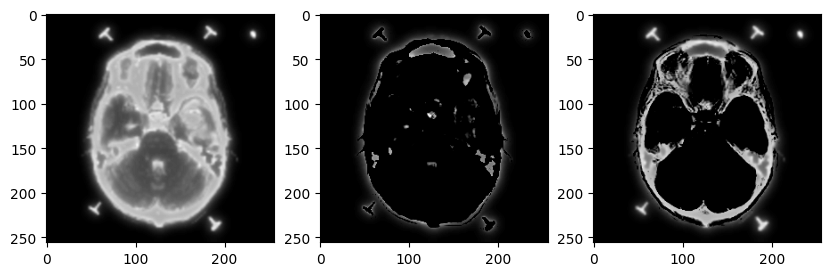

In [50]:
import cv2
import numpy as np

def build_laplacian_pyramid(image, levels):
    target_size = (256, 256)
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], expanded)
        laplacian_pyramid.append(laplacian)
        # print(cv2.resize(laplacian, target_size).shape)
    
    return laplacian_pyramid

def blend_images(image1, image2, levels):
    target_size = (256, 256)
    laplacian_pyramid1 = build_laplacian_pyramid(image1, levels)
    laplacian_pyramid2 = build_laplacian_pyramid(image2, levels)
    
    blended_pyramid = []
    for lap1, lap2 in zip(laplacian_pyramid1, laplacian_pyramid2):
        blended = np.where(np.abs(lap1) > np.abs(lap2), lap1, lap2)
        blended_pyramid.append(blended)
    
    blended_image = blended_pyramid[0]
    for i in range(1, levels - 1):
        blended_image = cv2.pyrUp(blended_image)
        blended_image = cv2.add(blended_pyramid[i], blended_image) // 2

    return blended_image
# 指定金字塔的级别数量
levels = 4

# 图像融合
blended_image = blend_images(CT, MRI, levels)
blended_image = cv2.pyrUp(blended_image)
print(blended_image.shape, CT.shape)
diff_CT = cv2.subtract(blended_image, CT)
diff_MRI = cv2.subtract(blended_image, MRI)


plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(blended_image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(diff_CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(diff_MRI, cmap='gray')

plt.show()
# 显示融合后的图像

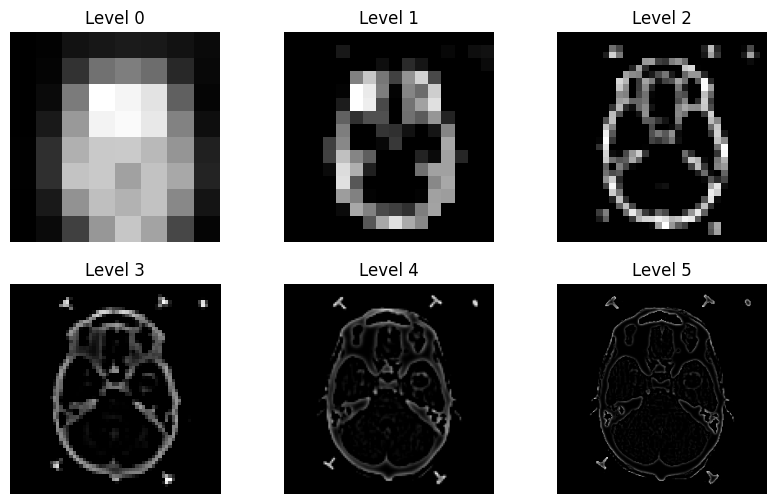

In [51]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_laplacian_pyramid(image, levels):
    # 构建高斯金字塔
    gaussian_pyramid = [image]
    for i in range(levels - 1):
        image = cv2.pyrDown(image)
        gaussian_pyramid.append(image)
    
    # 构建拉普拉斯金字塔
    laplacian_pyramid = [gaussian_pyramid[levels - 1]]
    for i in range(levels - 1, 0, -1):
        gaussian_expanded = cv2.pyrUp(gaussian_pyramid[i])
        laplacian = cv2.subtract(gaussian_pyramid[i - 1], gaussian_expanded)
        laplacian_pyramid.append(laplacian)
    
    return laplacian_pyramid

# 构建高斯-拉普拉斯金字塔
levels = 6
pyramid = gaussian_laplacian_pyramid(CT, levels)

# 创建subplot并显示金字塔中的图像
plt.figure(figsize=(10, 6))
for i in range(levels):
    plt.subplot(2, levels // 2, i + 1)
    plt.imshow(pyramid[i], cmap='gray')
    plt.title(f'Level {i}')
    plt.axis('off')

plt.show()

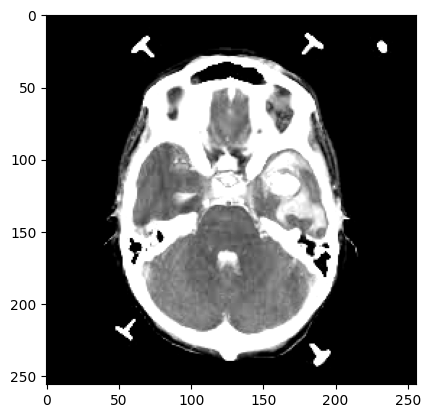

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 确保两幅图像大小相同
MRI = cv2.resize(MRI, (CT.shape[1], CT.shape[0]))

# 求两幅图像的最大值
new_img = np.maximum(CT, MRI)

# 显示融合后的图像
plt.imshow(new_img, cmap='gray')
plt.show()


In [53]:
print(MRI.shape)

(256, 256)


In [54]:
PATH = 'model/best/SiameseSAM_epoch10.pth'
SiameseSAM = build_siamese_sam(num_classes=num_classes, checkpoint=PATH).to(device)
SiameseSAM.eval()
laplacian_pyramid = LaplacianPyramid(levels=4, device='cuda')

In [55]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((256, 256))
        ])
inputs = [transform(CT), transform(MRI)]
inputs = [i.to(device).unsqueeze(0) for i in inputs]
laplacian_CT, laplacian_MRI = laplacian_pyramid.build_laplacian_pyramid_CT(inputs[0]), laplacian_pyramid.build_laplacian_pyramid_MRI(inputs[1])
inputs = [laplacian_CT[0], laplacian_MRI[0]]

In [56]:
output = SiameseSAM(inputs)
output[4] = laplacian_pyramid(output[4])

In [57]:
img = output[4][0].squeeze(0)

In [58]:
print(img[120][170])

tensor(1.1396, device='cuda:0', grad_fn=<SelectBackward0>)


(-0.5, 255.5, 255.5, -0.5)

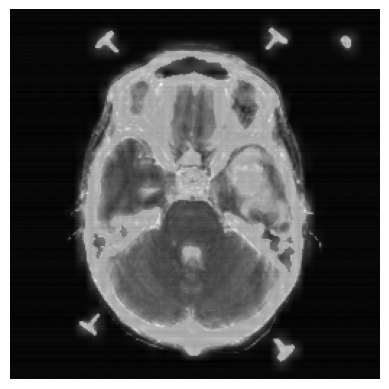

In [59]:
plt.imshow(img.detach().cpu(), cmap='gray')
plt.axis('off')

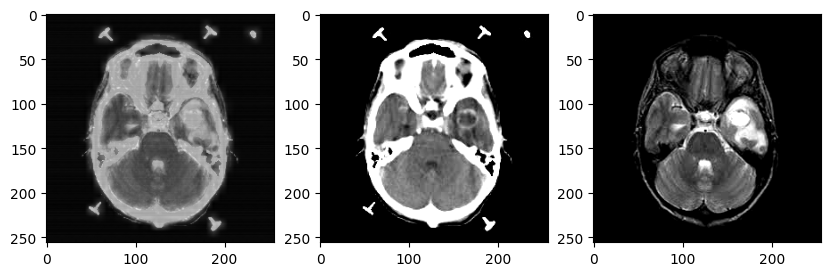

In [60]:
plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 1)
plt.imshow(img.detach().cpu(), cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(CT, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(MRI, cmap='gray')

In [61]:
import torch
import torch.nn.functional as F

# 定义 SSIM 损失函数
def ssim_loss(img1, img2, window_size=11, size_average=True):
    # 计算均值和方差
    mu1 = F.avg_pool2d(img1, window_size, stride=1, padding=0)
    mu2 = F.avg_pool2d(img2, window_size, stride=1, padding=0)
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2

    # 计算方差
    sigma1_sq = F.avg_pool2d(img1 ** 2, window_size, stride=1, padding=0) - mu1_sq
    sigma2_sq = F.avg_pool2d(img2 ** 2, window_size, stride=1, padding=0) - mu2_sq
    sigma12 = F.avg_pool2d(img1 * img2, window_size, stride=1, padding=0) - mu1_mu2

    # 计算 SSIM
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    if size_average:
        return torch.mean(ssim_map)
    else:
        return ssim_map


loss = ssim_loss(torch.tensor(MRI).unsqueeze(0).float(), img.unsqueeze(0).float().cpu())
print(f"SSIM Loss: {loss.item()}")


SSIM Loss: 0.5098460912704468
